## TODO
- map isoforms to real names and to genes
- make a per-gene plot of expression
- calculate TiP score
- calculate entropy

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('../../data/internal/GTEx-protein-gencode/protein.GC30-basic.txt',
                 sep='\t')
metadata = pd.read_csv('../../data/internal/GTEx-protein-gencode/SRA-filtered.txt',
                       sep='\t')
if metadata['UID'].duplicated().any():
    raise UserWarning('Unexpected duplicates')
metadata = metadata.set_index('UID')
if df.columns.duplicated().any():
    raise UserWarning('Unexpected duplicates')
if df['UID'].duplicated().any():
    raise UserWarning('Unexpected duplicates')
df = df.set_index('UID')

In [5]:
metadata.head()

,Sample_Name,biospecimen_repository_sample_id,body_site,Unnamed: 4,histological_type,molecular_data_type,sex
UID,,,,,,,
SRR1359447_1,GTEX-11TT1-2426-SM-5EQMK,GTEX-11TT1-2426-SM-5EQMK,Adipose - Subcutaneous,NaN,Adipose Tissue,RNA Seq (NGS),male
SRR1362310_1,GTEX-11ZUS-0726-SM-59886,GTEX-11ZUS-0726-SM-59886,Adipose - Subcutaneous,NaN,Adipose Tissue,Allele-Specific Expression,male
SRR1363968_1,GTEX-1269C-2726-SM-5EGJ4,GTEX-1269C-2726-SM-5EGJ4,Adipose - Subcutaneous,NaN,Adipose Tissue,Allele-Specific Expression,female
SRR1380764_1,GTEX-12ZZX-0226-SM-5DUXU,GTEX-12ZZX-0226-SM-5DUXU,Adipose - Subcutaneous,NaN,Adipose Tissue,RNA Seq (NGS),female
SRR1385501_1,GTEX-1211K-2226-SM-5FQU6,GTEX-1211K-2226-SM-5FQU6,Adipose - Subcutaneous,NaN,Adipose Tissue,RNA Seq (NGS),female


In [6]:
df.head()

,SRR1359447_1,SRR1362310_1,SRR1363968_1,SRR1380764_1,SRR1385501_1,SRR1416654_1,SRR1430549_1,SRR1431037_1,SRR1432253_1,SRR1445637_1,...,SRR1318605_1,SRR1318815_1,SRR1319461_1,SRR1319772_1,SRR1320363_1,SRR1322619_1,SRR1343501_1,SRR1348294_1,SRR1348951_1,SRR1349032_1
UID,,,,,,,,,,,,,,,,,,,,,
GC grp: KCNIP3-201,0.000000,0.00000,0.822561,0.498674,0.000000e+00,0.000000,0.000000,0.000000,0.437251,0.000000,...,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.000000
GC grp: KCNIP3-202,4.113570,6.21722,2.790300,2.844410,4.950400e+00,1.468680,2.207630,6.272550,3.121830,5.697990,...,0.0,0.07017,0.00381,0.022582,0.031209,0.011933,0.0,0.000000e+00,0.021295,0.036221
GC grp: KCNIP3-205,0.755222,1.53579,0.331456,1.168660,8.493150e-01,0.403626,0.478670,1.757320,0.824661,1.617940,...,0.0,0.00000,0.00000,0.000000,0.000000,0.018183,0.0,0.000000e+00,0.000000,0.000000
GC grp: TFDP2-209,0.043638,0.00000,0.000000,0.000000,4.450000e-07,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.09502,0.00000,0.000000,0.000000,0.193163,0.0,3.060000e-10,0.000000,0.000000
GC grp: NFATC2-206,0.000000,0.00000,0.000000,0.153301,9.080060e-01,0.000000,0.254371,0.047617,0.160193,0.236699,...,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.000000


In [62]:
means = df.groupby(df.columns.map(metadata['body_site']), axis=1).mean()
medians = df.groupby(df.columns.map(metadata['body_site']), axis=1).median()

In [50]:
genes = pd.Series(index=df.index,
                  data=df.index.str.extract('GC grp\: ([A-Z0-9orf]{2,10})-.*', expand=False).values)

In [25]:
#genes = pd.read_csv('../../data/internal/GTEx-protein-gencode/a_gencode30_uniq_prot_and_annot_sachi_gloria_lambert.tsv',
#                    sep='\t')
#genes = (genes.loc[:, ['same_prot_seq_name', 'orig_gene']]
#              .drop_duplicates()
#              .set_index('same_prot_seq_name')['orig_gene'])

Text(0.5, 1.0, 'TFDP2')

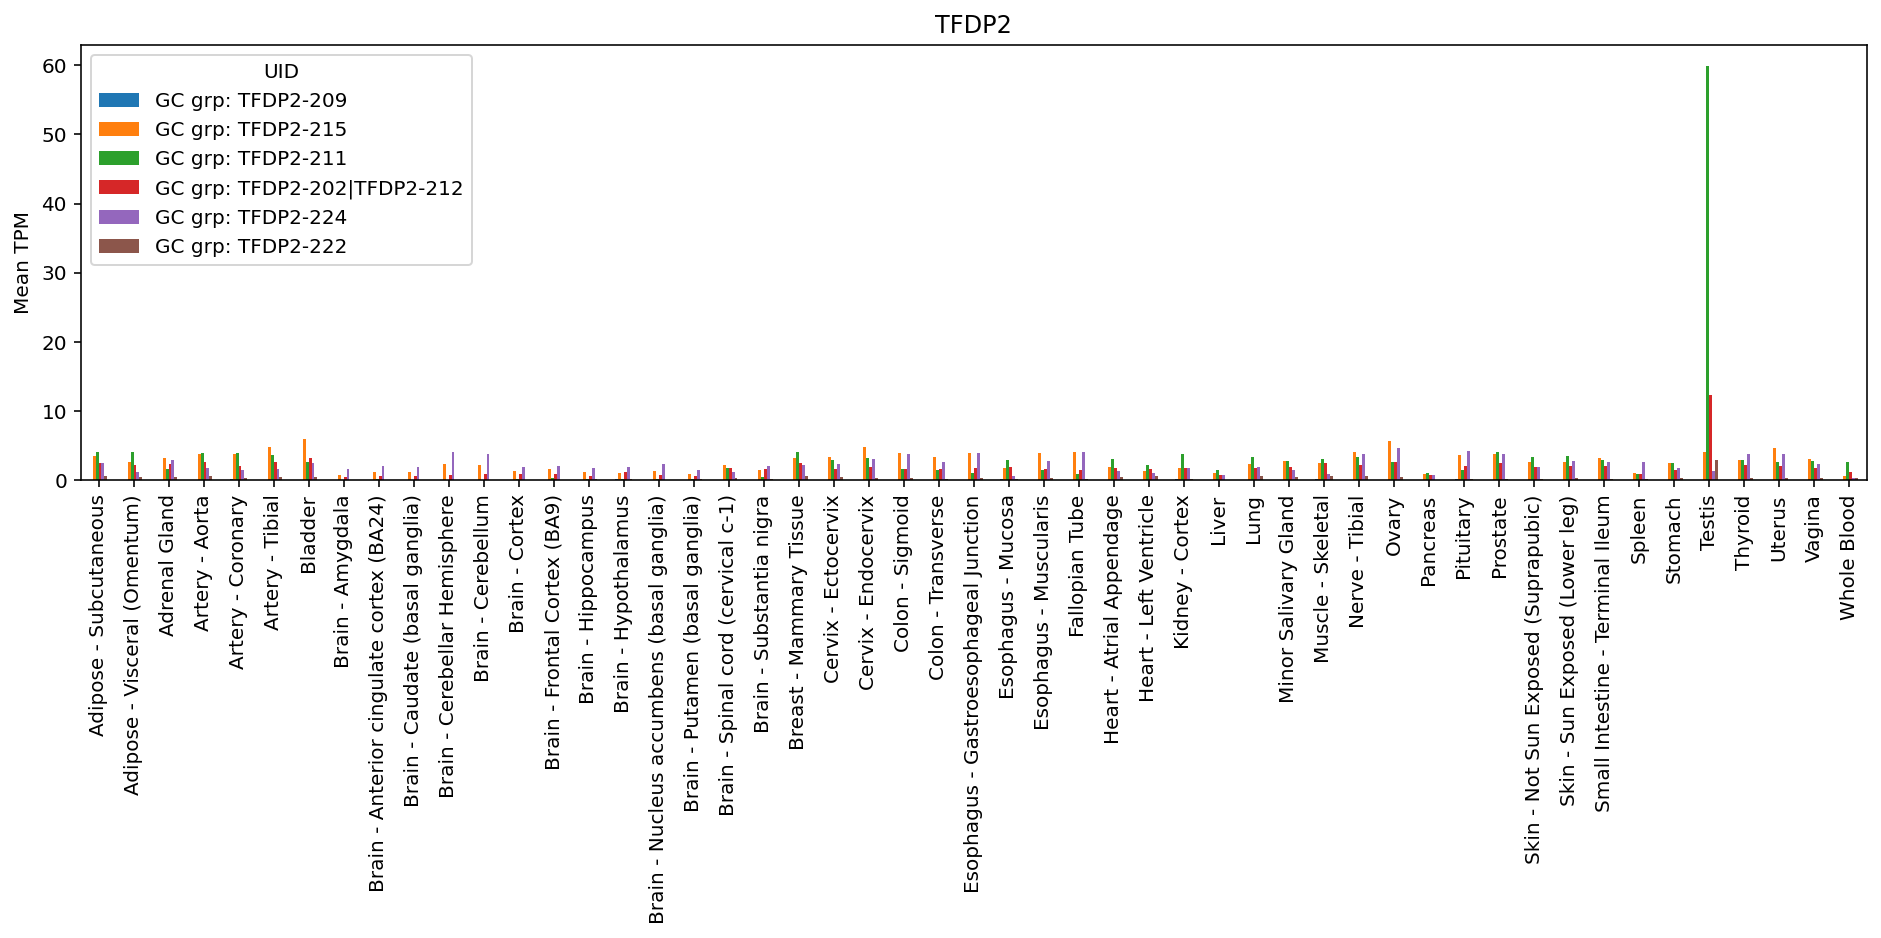

In [91]:
#gene_name = 'KCNIP3'
gene_name = 'TFDP2'

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16, 4)
means.loc[genes == gene_name, :].T.plot.bar(ax=ax)
ax.set_ylabel('Mean TPM')
ax.set_title(gene_name)

In [69]:
# TiP: medians
tip_score = (medians - medians.median(axis=1)) / (medians.quantile(q=0.75, axis=1) - medians.quantile(q=0.25, axis=1))

In [89]:
medians.sub(medians.median(axis=1), axis=0).div(medians.quantile(q=0.75, axis=1) - medians.quantile(q=0.25, axis=1), axis=0)

,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),...,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
UID,,,,,,,,,,,,,,,,,,,,,
GC grp: KCNIP3-201,-0.240512,-0.215431,-0.343498,0.125802,-0.131727,-0.193286,-0.063236,3.118680,5.590174,3.010453,...,-0.064323,-0.066982,-0.185120,-0.258041,-0.174895,0.000000,3.265300,0.019732,0.089892,-0.343498
GC grp: KCNIP3-202,0.241957,0.212689,-0.203250,0.253746,0.530640,0.656054,0.799110,-0.181881,-0.291816,-0.336785,...,0.021906,0.318650,0.000000,-0.029717,-0.095848,1.282182,1.056533,1.115091,0.854967,-0.335595
GC grp: KCNIP3-205,0.368640,0.280476,-0.254964,0.395294,0.523909,0.756328,2.012208,-0.338439,-0.334441,-0.362453,...,0.098625,0.458737,0.072924,-0.212603,-0.009481,1.424835,1.683991,1.354389,0.806623,-0.448900
GC grp: TFDP2-209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GC grp: NFATC2-206,2.095273,1.627778,0.000000,0.922969,0.000000,1.849145,1.324630,0.000000,0.000000,0.000000,...,0.000000,2.084477,0.476464,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GC grp: ZNF93-206,0.227732,-0.087000,-0.425050,-0.138461,-0.016012,-0.467261,1.033873,-0.772116,-0.254284,0.317963,...,0.579952,0.606720,0.343386,0.473473,-0.388279,1.252165,1.868985,2.553904,1.100005,-1.167687
GC grp: ZNF93-201,0.149520,0.296200,-0.076839,-0.456814,-0.281836,-0.521897,1.497290,-0.790076,-0.707762,-0.328964,...,0.345886,0.253769,0.307248,0.799230,0.009047,2.362089,2.915753,1.603695,0.451226,-0.644220
GC grp: ZNF556-201,0.210998,0.000000,-0.361929,0.220171,-0.036248,-0.095791,0.360816,-0.787316,-0.710873,-0.674361,...,0.117998,0.160910,0.170647,0.746657,-0.462913,1.927575,0.887853,1.226620,0.385790,-0.407630


In [90]:
medians.quantile(q=0.75, axis=1) - medians.quantile(q=0.25, axis=1)

UID
GC grp: KCNIP3-201    3.344354
GC grp: KCNIP3-202    6.257652
GC grp: KCNIP3-205    1.191468
GC grp: TFDP2-209     0.000000
GC grp: NFATC2-206    0.023435
                        ...   
GC grp: ZNF93-206     0.457645
GC grp: ZNF93-201     0.811900
GC grp: ZNF556-201    0.362581
GC grp: ZNF556-202    0.000000
GC grp: HOXD10-201    1.638920
Length: 4130, dtype: float64